In [1]:
import numpy as np
import pandas as pd
import random

import torch
import torch.nn as nn
import torch.nn.functional as F

import seaborn as sns
import matplotlib.pyplot as plt
import os

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from collections import OrderedDict
from tqdm import tqdm

import warnings
warnings.filterwarnings("ignore")

C:\Users\ladwi\anaconda3\envs\deeplearning\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# CUDA support 
if torch.cuda.is_available():
    device = torch.device('cuda:2')
else:
    device = torch.device('cpu')
    
print(device)
device = torch.device('cpu')

cuda:2


In [3]:
# the deep neural network
class MLP(torch.nn.Module):
    def __init__(self, layers, activation="relu", init="xavier"):
        super(MLP, self).__init__()
        
        # parameters
        self.depth = len(layers) - 1
        
        if activation == "relu":
            self.activation = torch.nn.ReLU()
        elif activation == "tanh":
            self.activation = torch.nn.Tanh()
        elif activation == "gelu":
            self.activation = torch.nn.GELU()
        else:
            raise ValueError("Unspecified activation type")
        
        
        layer_list = list()
        for i in range(self.depth - 1): 
            layer_list.append(
                ('layer_%d' % i, torch.nn.Linear(layers[i], layers[i+1]))
            )
            layer_list.append(('activation_%d' % i, self.activation))
            
        layer_list.append(
            ('layer_%d' % (self.depth - 1), torch.nn.Linear(layers[-2], layers[-1]))
        )
        layerDict = OrderedDict(layer_list)
        
        # deploy layers
        self.layers = torch.nn.Sequential(layerDict)

        if init=="xavier":
            self.xavier_init_weights()
        elif init=="kaiming":
            self.kaiming_init_weights()
    
    def xavier_init_weights(self):
        with torch.no_grad():
            print("Initializing Network with Xavier Initialization..")
            for m in self.layers.modules():
                if hasattr(m, 'weight'):
                    nn.init.xavier_uniform_(m.weight)
                    m.bias.data.fill_(0.0)

    def kaiming_init_weights(self):
        with torch.no_grad():
            print("Initializing Network with Kaiming Initialization..")
            for m in self.layers.modules():
                if hasattr(m, 'weight'):
                    nn.init.kaiming_uniform_(m.weight)
                    m.bias.data.fill_(0.0)
                        
    def forward(self, x):
        out = self.layers(x)
        return out
    
class DataGenerator(torch.utils.data.Dataset):
    def __init__(self, X, Y):
        self.X = X
        self.Y = Y
        
    def __getitem__(self, index):
        return self.X[index], self.Y[index]
    
    def __len__(self):
        return len(self.X)

In [4]:
data_df = pd.read_csv("all_data_lake_modeling_in_time.csv")
data_df = data_df.drop(columns=['time'])
data_df

,depth,AirTemp_degC,Longwave_Wm-2,Latent_Wm-2,Sensible_Wm-2,Shortwave_Wm-2,lightExtinct_m-1,ShearVelocity_mS-1,ShearStress_Nm-2,Area_m2,...,temp_total04,buoyancy,diffusivity,temp_diff01,day_of_year,time_of_day,temp_mix02,temp_conv03,obs_temp,input_obs
0,1,10.715021,678.292163,-152.775961,-4.194743,0.0,0.255324,1.085796,0.002290,36000000.0,...,11.570472,0.000000,0.000037,11.467275,155,1,11.545011,11.570472,16.409,16.350
1,2,10.715021,678.292163,-152.775961,-4.194743,0.0,0.255324,1.085796,0.002290,36000000.0,...,11.570472,0.000000,0.000037,11.627332,155,1,11.545011,11.570472,16.480,16.426
2,3,10.715021,678.292163,-152.775961,-4.194743,0.0,0.255324,1.085796,0.002290,36000000.0,...,11.575860,0.000271,0.000021,11.631393,155,1,11.631393,11.575860,16.130,16.088
3,4,10.715021,678.292163,-152.775961,-4.194743,0.0,0.255324,1.085796,0.002290,36000000.0,...,11.393058,0.000278,0.000021,11.393058,155,1,11.393058,11.393058,15.827,15.789
4,5,10.715021,678.292163,-152.775961,-4.194743,0.0,0.255324,1.085796,0.002290,36000000.0,...,11.130929,0.000185,0.000024,11.130929,155,1,11.130929,11.130929,16.270,16.240
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
106170,21,28.094995,952.008506,-72.970251,-73.622512,0.0,0.543757,1.701971,0.004728,36000000.0,...,7.039837,0.000329,0.000019,7.039837,213,23,7.039837,7.039837,11.407,11.407
106171,22,28.094995,952.008506,-72.970251,-73.622512,0.0,0.543757,1.701971,0.004728,36000000.0,...,6.216154,0.000227,0.000022,6.216154,213,23,6.216154,6.216154,11.407,11.407
106172,23,28.094995,952.008506,-72.970251,-73.622512,0.0,0.543757,1.701971,0.004728,36000000.0,...,5.401328,0.000127,0.000029,5.401328,213,23,5.401328,5.401328,11.407,11.407
106173,24,28.094995,952.008506,-72.970251,-73.622512,0.0,0.543757,1.701971,0.004728,36000000.0,...,4.590689,0.000026,0.000037,4.590689,213,23,4.590689,4.590689,11.407,11.407


In [5]:
training_frac = 0.60
depth_steps = 25
number_days = len(data_df)//depth_steps
n_obs = int(number_days*training_frac)*depth_steps
print(f"Number of days total: {number_days}")
print(f"Number of training points: {n_obs}")

Number of days total: 4247
Number of training points: 63700


# Normalizing Data

In [6]:
data = data_df.values

train_data = data[:n_obs]
test_data = data[n_obs:]

#performing normalization on all the columns
scaler = StandardScaler()
scaler.fit(train_data)
train_data = scaler.transform(train_data)
test_data = scaler.transform(test_data)

# Training Heat Diffusion Model

In [7]:
input_columns = ['depth', 'AirTemp_degC', 'Longwave_Wm-2', 'Latent_Wm-2', 'Sensible_Wm-2', 'Shortwave_Wm-2',
                'lightExtinct_m-1', 'ShearVelocity_mS-1', 'ShearStress_Nm-2', 'Area_m2', 
                'day_of_year', 'time_of_day']#, 'input_obs'] 
output_columns = ['obs_temp']

input_column_ix = [data_df.columns.get_loc(column) for column in input_columns]
output_column_ix = [data_df.columns.get_loc(column) for column in output_columns]

X_train, X_test = train_data[:,input_column_ix], test_data[:,input_column_ix]
y_train, y_test = train_data[:,output_column_ix], test_data[:,output_column_ix]

In [8]:
print(f"X_train: {X_train.shape}, X_test: {X_test.shape}")
print(f"y_train: {y_train.shape}, y_test: {y_test.shape}")

X_train: (63700, 12), X_test: (42475, 12)
y_train: (63700, 1), y_test: (42475, 1)


In [9]:
#keeping track of the mean and standard deviations
train_mean = scaler.mean_
train_std = scaler.scale_

input_mean, input_std = train_mean[input_column_ix], train_std[input_column_ix]
output_mean, output_std = train_mean[output_column_ix], train_std[output_column_ix]

In [10]:
# Create data set
batch_size = 1024
train_dataset = DataGenerator(X_train, y_train)
test_dataset = DataGenerator(X_test, y_test)
# train_dataset = torch.utils.data.TensorDataset(X_train, y_train)
# test_dataset = torch.utils.data.TensorDataset(X_test, y_test)
print(X_train.shape)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, 
                                           shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size,
                                          shuffle=False)

(63700, 12)


In [11]:
layers = [X_train.shape[-1], 32, 32, y_train.shape[-1]]

model = MLP(layers, activation="gelu").to(device)

Initializing Network with Xavier Initialization..


In [12]:
lr = 1e-3
decay_rate = 0.1
decay_steps = 500
    
optimizer = torch.optim.Adam(model.parameters(), lr=lr, 
                         betas=(0.9, 0.999), eps=1e-08, weight_decay=0, amsgrad=False)
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=decay_steps, gamma=decay_rate)

criterion = torch.nn.MSELoss()

In [13]:
print(model)

MLP(
  (activation): GELU()
  (layers): Sequential(
    (layer_0): Linear(in_features=12, out_features=32, bias=True)
    (activation_0): GELU()
    (layer_1): Linear(in_features=32, out_features=32, bias=True)
    (activation_1): GELU()
    (layer_2): Linear(in_features=32, out_features=1, bias=True)
  )
)


In [14]:
n_epochs = 1000

train_loss = []
test_loss = []
for it in tqdm(range(n_epochs)):
    loss_epoch = 0
    model.train()
    for x, y in iter(train_loader):
        x, y = x.to(device).float(), y.to(device).float()
        optimizer.zero_grad()
        pred = model(x)
        loss = criterion(pred, y)
        loss.backward()
        optimizer.step()
        loss_epoch += loss.detach().item()
    lr_scheduler.step()
    
    if it % 50 == 0:
        train_loss.append(loss_epoch/len(train_loader))
        model.eval()
        test_loss_epoch = 0
        for x, y in iter(test_loader):
            x, y = x.to(device).float(), y.to(device).float()
            pred = model(x)
            loss = criterion(pred, y)
            test_loss_epoch += loss.detach().item()
        test_loss.append(test_loss_epoch/len(test_loader))
        print(f"Epoch : {it}, Train_loss: {train_loss[-1]}, Test_loss: {test_loss[-1]}")
    

  0%|                                                                                 | 1/1000 [00:00<12:02,  1.38it/s]

Epoch : 0, Train_loss: 0.40901930914038703, Test_loss: 0.3592189575235049


  5%|████                                                                            | 51/1000 [00:22<07:43,  2.05it/s]

Epoch : 50, Train_loss: 0.024595429706904624, Test_loss: 0.1034549813540209


 10%|███████▉                                                                       | 101/1000 [00:43<07:18,  2.05it/s]

Epoch : 100, Train_loss: 0.019700356079117645, Test_loss: 0.13021742459386587


 15%|███████████▉                                                                   | 151/1000 [01:05<07:38,  1.85it/s]

Epoch : 150, Train_loss: 0.017613357642576807, Test_loss: 0.1678042999867882


 20%|███████████████▉                                                               | 201/1000 [01:29<06:55,  1.92it/s]

Epoch : 200, Train_loss: 0.016287688742436114, Test_loss: 0.21896543642062516


 25%|███████████████████▊                                                           | 251/1000 [01:53<07:00,  1.78it/s]

Epoch : 250, Train_loss: 0.01564548902272705, Test_loss: 0.22709930461964437


 30%|███████████████████████▊                                                       | 301/1000 [02:15<05:32,  2.10it/s]

Epoch : 300, Train_loss: 0.015038678200826758, Test_loss: 0.20426219480023497


 35%|███████████████████████████▋                                                   | 351/1000 [02:36<05:35,  1.94it/s]

Epoch : 350, Train_loss: 0.014554309525660105, Test_loss: 0.20836386093426318


 40%|███████████████████████████████▋                                               | 401/1000 [02:58<04:52,  2.04it/s]

Epoch : 400, Train_loss: 0.01421883993501228, Test_loss: 0.23401850590571052


 45%|███████████████████████████████████▋                                           | 451/1000 [03:19<04:32,  2.01it/s]

Epoch : 450, Train_loss: 0.013955048935872221, Test_loss: 0.18979239437196935


 50%|███████████████████████████████████████▌                                       | 501/1000 [03:40<04:08,  2.01it/s]

Epoch : 500, Train_loss: 0.013350352275347898, Test_loss: 0.17880832887299003


 55%|███████████████████████████████████████████▌                                   | 551/1000 [04:02<03:44,  2.00it/s]

Epoch : 550, Train_loss: 0.01336938107297534, Test_loss: 0.1833054924472457


 60%|███████████████████████████████████████████████▍                               | 601/1000 [04:25<03:38,  1.82it/s]

Epoch : 600, Train_loss: 0.013141077351830309, Test_loss: 0.1845959544714008


 65%|███████████████████████████████████████████████████▍                           | 651/1000 [04:49<03:11,  1.82it/s]

Epoch : 650, Train_loss: 0.01311711190889279, Test_loss: 0.1887507379232418


 70%|███████████████████████████████████████████████████████▍                       | 701/1000 [05:14<02:54,  1.72it/s]

Epoch : 700, Train_loss: 0.013094507645638217, Test_loss: 0.18885351553381907


 75%|███████████████████████████████████████████████████████████▎                   | 751/1000 [05:37<02:14,  1.85it/s]

Epoch : 750, Train_loss: 0.013011152545611063, Test_loss: 0.1915691757042493


 80%|███████████████████████████████████████████████████████████████▎               | 801/1000 [05:59<01:40,  1.97it/s]

Epoch : 800, Train_loss: 0.013028660582171546, Test_loss: 0.19387102051682414


 85%|███████████████████████████████████████████████████████████████████▏           | 851/1000 [06:21<01:12,  2.05it/s]

Epoch : 850, Train_loss: 0.012980088414180847, Test_loss: 0.19520868941964137


 90%|███████████████████████████████████████████████████████████████████████▏       | 901/1000 [06:45<00:53,  1.85it/s]

Epoch : 900, Train_loss: 0.012991224903435935, Test_loss: 0.19801650218488204


 95%|███████████████████████████████████████████████████████████████████████████▏   | 951/1000 [07:06<00:24,  2.01it/s]

Epoch : 950, Train_loss: 0.012873394754789179, Test_loss: 0.19881518291575567


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [07:27<00:00,  2.24it/s]


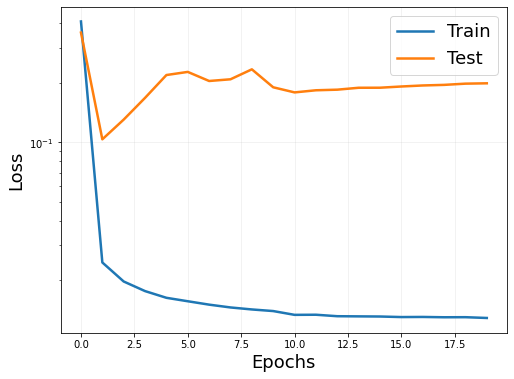

In [15]:
plt.figure(figsize=(8,6))
plt.plot(train_loss, label="Train", linewidth=2.5)
plt.plot(test_loss, label="Test", linewidth=2.5)
plt.grid("on", alpha=0.2)
plt.legend(fontsize=18)
plt.yscale("log")
plt.xlabel("Epochs", fontsize=18)
plt.ylabel("Loss", fontsize=18)
plt.show()

# Evaluating Results

In [16]:
def rmse(true, pred):
    return (((true-pred)**2).mean()**0.5).detach().cpu().numpy()

def l2_error(true, pred):
    return np.linalg.norm(pred.detach().cpu().numpy() - true.detach().cpu().numpy()) / np.linalg.norm(true.detach().cpu().numpy()) 

def compute_metrics(model, loader, mean=0.0, std=1.0):
    model.eval()
    y_ = []
    pred_ = []
    mean = torch.tensor(mean).to(device)
    std = torch.tensor(std).to(device)
    for x, y in iter(loader):
        x, y = x.to(device).float(), y.to(device).float()
        pred = model(x)
        y = y * std + mean
        pred = pred * std + mean
        y_.append(y)
        pred_.append(pred)
    y_ = torch.cat(y_, dim=0) 
    pred_ = torch.cat(pred_, dim=0)
    
    rmse_temp = rmse(y_[:,0], pred_[:,0])
    
    l2_error_temp = l2_error(y_[:,0], pred_[:,0])
    return rmse_temp, l2_error_temp

In [17]:
rmse_temp, l2_error_temp = compute_metrics(model, test_loader,  mean = output_mean, std = output_std)
print(f"Test Rmse of Temp: {rmse_temp}")

print(f"L2 Error  of Temp: {l2_error_temp}")

Test Rmse of Temp: 1.9345582799895742
L2 Error  of Temp: 0.1145353061908596


In [18]:
rmse_temp, l2_error_temp = compute_metrics(model, train_loader,  mean = output_mean, std = output_std)
print(f"Train Rmse of Temp: {rmse_temp}")

print(f"L2 Error  of Temp: {l2_error_temp}")

Train Rmse of Temp: 0.4927555521973338
L2 Error  of Temp: 0.030430849509925945


# Saving Model

In [19]:
PATH = f"./saved_models/no_process_model_time.pth"
torch.save(model.state_dict(), PATH)

In [20]:
output_mean

array([15.59964124])

In [21]:
def plot_output(y_pred, y_true, depth_steps, time_label, figsize=(20,20)):
    time_label = np.array([time[:10] for time in time_label])
    time_label = time_label[::depth_steps]
    
    y_pred = y_pred.flatten().detach().cpu().numpy()
    y_true = y_true.flatten().detach().cpu().numpy()
    
    y_true = np.reshape(y_true, (y_true.shape[0]//depth_steps, depth_steps))
    y_pred = np.reshape(y_pred, (y_pred.shape[0]//depth_steps, depth_steps))
    
    N_pts = 6 # number of points to display on the x-label
    
    fig, ax = plt.subplots(3, 1, figsize=figsize)
    sns.heatmap(y_true.T, ax=ax[0], cmap='coolwarm', vmin=0., vmax=30.)#seismic
    ax[0].set_ylabel("Depth", fontsize=15)
    ax[0].set_xlabel("Time", fontsize=15)
    
    xticks_ix = np.array(ax[0].get_xticks()).astype(int)
    time_label = time_label[xticks_ix]
    nelement = len(time_label)//N_pts
    time_label = time_label[::nelement]
    ax[0].xaxis.set_major_locator(plt.MaxNLocator(N_pts+1))
    ax[0].set_xticklabels(time_label, rotation=0, fontsize =20) 
    ax[0].tick_params(axis='y', labelsize=10)
#     ax[0].xaxis.set_major_locator(plt.MultipleLocator(100))
    ax[0].collections[0].colorbar.set_label("Actual Temperature", fontsize =15)
    
    sns.heatmap(y_pred.T, ax=ax[1], cmap='coolwarm', vmin=0., vmax=30.)
    ax[1].set_ylabel("Depth", fontsize=15)
    ax[1].set_xlabel("Time", fontsize=15)
    ax[1].xaxis.set_major_locator(plt.MaxNLocator(N_pts+1))
    ax[1].set_xticklabels(time_label, rotation=0, fontsize =20)
    ax[1].tick_params(axis='y', labelsize=10)
    ax[1].collections[0].colorbar.set_label("Predicted Temperature", fontsize =15)
    
    sns.heatmap(np.abs(y_pred.T-y_true.T), ax=ax[2], cmap='viridis')
    ax[2].set_ylabel("Depth", fontsize=15)
    ax[2].set_xlabel("Time", fontsize=15)
    ax[2].xaxis.set_major_locator(plt.MaxNLocator(N_pts+1))
    ax[2].set_xticklabels(time_label, rotation=0, fontsize =20)
    ax[2].tick_params(axis='y', labelsize=10)
    
    ax[2].collections[0].colorbar.set_label("Absolute Error", fontsize =15)
    plt.show()

In [22]:
class DataGenerator(torch.utils.data.Dataset):
    def __init__(self, X):
        self.X = X
        
    def __getitem__(self, index):
        return self.X[index]
    
    def __len__(self):
        return len(self.X)

data_df = pd.read_csv("all_data_lake_modeling_in_time.csv")
time = data_df['time']
data_df = data_df.drop(columns=['time'])
data_df

data = data_df.values

train_data = data[:n_obs]
test_data = data[n_obs:]

train_time = time[:n_obs]
test_time = time[n_obs:]
print(train_time)
print(test_time)

#performing normalization on all the columns
scaler = StandardScaler()
scaler.fit(train_data)
train_data = scaler.transform(train_data)
test_data = scaler.transform(test_data)

# Create data set
batch_size = 1024
train_dataset = DataGenerator(train_data)
test_dataset = DataGenerator(test_data)
# train_dataset = torch.utils.data.TensorDataset(X_train, y_train)
# test_dataset = torch.utils.data.TensorDataset(X_test, y_test)
print(train_data.shape)


train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, 
                                           shuffle=False)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size,
                                          shuffle=False)

obs_temp_columns = ['obs_temp']

obs_temp_columns_ix = [data_df.columns.get_loc(column) for column in obs_temp_columns]

0        2009-06-04 01:00:00
1        2009-06-04 01:00:00
2        2009-06-04 01:00:00
3        2009-06-04 01:00:00
4        2009-06-04 01:00:00
                ...         
63695    2010-07-21 04:00:00
63696    2010-07-21 04:00:00
63697    2010-07-21 04:00:00
63698    2010-07-21 04:00:00
63699    2010-07-21 04:00:00
Name: time, Length: 63700, dtype: object
63700     2010-07-21 05:00:00
63701     2010-07-21 05:00:00
63702     2010-07-21 05:00:00
63703     2010-07-21 05:00:00
63704     2010-07-21 05:00:00
                 ...         
106170    2011-08-01 23:00:00
106171    2011-08-01 23:00:00
106172    2011-08-01 23:00:00
106173    2011-08-01 23:00:00
106174    2011-08-01 23:00:00
Name: time, Length: 42475, dtype: object
(63700, 21)


In [23]:
def get_rollout_predictions(no_process_model, loader, plot = True):    
    no_process_model.eval()

    mean = torch.tensor(train_mean[output_column_ix]).float().to(device)
    std = torch.tensor(train_std[output_column_ix]).float().to(device)

    m1_mean = torch.tensor(train_mean[input_column_ix[-1]]).float().to(device)
    m1_std = torch.tensor(train_std[input_column_ix[-1]]).float().to(device)

#     depthwise_y_pred = []
#     depthwise_y_true = []
    y_ = []
    y_obs_ = []
    pred_ = []
        
    rmse_models = np.zeros((len(loader), 1))
    for ix, x in enumerate(iter(loader)):
        print(x)
        print(x.shape)
        x = x.to(device).float()
        
        print(x)
        print(x.shape)
        m1_input = x[:, m1_input_column_ix]
        
            
        #model 1
        m1_pred = no_process_model(m1_input) #predicts diff and temp
        print(m1_pred.shape)
        m1_pred_temp = m1_pred#[:,1:2]
        print(m1_pred_temp.shape)
        print(m1_pred_temp)
            
        if plot:
            
            m1_y_true = x[:, m1_output_column_ix[0]] * torch.tensor(train_std[m1_output_column_ix[0]]).to(device) + torch.tensor(train_mean[m1_output_column_ix[0]]).to(device)
            m1_y_pred = m1_pred_temp * torch.tensor(train_std[m1_output_column_ix[0]]).to(device) + torch.tensor(train_mean[m1_output_column_ix[0]]).to(device)
#             print(m1_y_true.shape, m1_y_pred.shape)
#             print("True",m1_y_true)
#             print("Pred",m1_y_pred)

#             print(m1_y_true.shape)
#             print(m1_y_pred.shape)
            rmse_models[ix, 0] = rmse(m1_y_true.squeeze(), m1_y_pred.squeeze())
#             print(x[:, m1_output_column_ix[1]])
#             print(m1_pred_temp)
#             print(criterion(m1_pred_temp, x[:, m1_output_column_ix[1]]))
#                 print("RMSE of after m1", rmse(m1_y_true.flatten(), m1_y_pred.flatten()))

#         #model 2
#         m2_input = torch.cat([x[:, m2_input_column_ix[:-1]], m1_pred_temp], dim=-1)
#         m2_pred = mixing_model(m2_input)
            
#         if plot:
#             m2_y_true = x[:, m2_output_column_ix] * torch.tensor(train_std[m2_output_column_ix[0]]).to(device) + torch.tensor(train_mean[m2_output_column_ix[0]]).to(device)
#             m2_y_pred = m2_pred * torch.tensor(train_std[m2_output_column_ix[0]]).to(device) + torch.tensor(train_mean[m2_output_column_ix[0]]).to(device)
#             rmse_models[ix, 1] = rmse(m2_y_true.squeeze(), m2_y_pred.squeeze())
# #                 print("RMSE of after m2", rmse(m2_y_true.flatten(), m2_y_pred.flatten()))

#         #model 3
#         m3_input = torch.cat([x[:, m3_input_column_ix[:-1]], m2_pred], dim=-1)
#         m3_pred = convection_model(m3_input)
            
#         if plot:
#             m3_y_true = x[:, m3_output_column_ix] * torch.tensor(train_std[m3_output_column_ix[0]]).to(device) + torch.tensor(train_mean[m3_output_column_ix[0]]).to(device)
#             m3_y_pred = m3_pred * torch.tensor(train_std[m3_output_column_ix[0]]).to(device) + torch.tensor(train_mean[m3_output_column_ix[0]]).to(device)
#             rmse_models[ix, 2] = rmse(m3_y_true.squeeze(), m3_y_pred.squeeze())
# #                 print("RMSE of after m3", rmse(m3_y_true.flatten(), m3_y_pred.flatten()))

#         #model 4
#         m4_input = torch.cat([x[:, m4_input_column_ix[:-1]], m3_pred], dim=-1)
#         m4_pred = ice_model(m4_input)
            
#         if plot:
#             m4_y_true = x[:, m4_output_column_ix] * std + mean
#             m4_y_pred = m4_pred * std + mean
#             rmse_models[ix, 3] = rmse(m4_y_true.squeeze(), m4_y_pred.squeeze())
# #                 print("RMSE of after m4", rmse(m4_y_true.flatten(), m4_y_pred.flatten()))

        y_true = x[:, m1_output_column_ix] * std + mean
        y_obs = x[:, obs_temp_columns_ix] * train_std[obs_temp_columns_ix[0]] + train_mean[obs_temp_columns_ix[0]]
        pred = m1_pred_temp * std + mean
        
        y_.append(y_true)
        y_obs_.append(y_obs)
        pred_.append(pred)

    y_ = torch.cat(y_, dim=0)
    y_obs_ = torch.cat(y_obs_, dim=0)
    pred_ = torch.cat(pred_, dim=0) 
    
#     if plot:
#         rmse_models = rmse_models.mean(axis=0)
#         plt.figure(figsize=(12,8))
#         plt.plot(rmse_models[:, 0], label="RMSE after Heat-Diffusion Model")
#         plt.plot(rmse_models[:, 1], label="RMSE after Mixing Model")
#         plt.plot(rmse_models[:, 2], label="RMSE after Convection Model")
#         plt.plot(rmse_models[:, 3], label="RMSE after Ice Model")
#         plt.legend(loc="upper left", fontsize=12)
#         plt.xlabel("Depth", fontsize=12)
#         plt.ylabel("RMSE", fontsize=12)
#         plt.grid("on", alpha=0.5)
#         plt.show()
    
    return pred_, y_, y_obs_, rmse_models


In [24]:
m1_input_columns = ['depth', 'AirTemp_degC', 'Longwave_Wm-2', 'Latent_Wm-2', 'Sensible_Wm-2', 'Shortwave_Wm-2',
                'lightExtinct_m-1', 'ShearVelocity_mS-1', 'ShearStress_Nm-2', 'Area_m2', 
                'day_of_year', 'time_of_day']#, 'input_obs'] 
m1_output_columns =['obs_temp']

m1_input_column_ix = [data_df.columns.get_loc(column) for column in input_columns]
m1_output_column_ix = [data_df.columns.get_loc(column) for column in output_columns]

m1_PATH = f"./saved_models/no_process_model_time.pth"
m1_layers = [len(m1_input_columns), 32, 32, len(m1_output_columns)]

no_process_model = MLP(m1_layers, activation="gelu")
m1_checkpoint = torch.load(m1_PATH, map_location=torch.device('cpu'))
no_process_model.load_state_dict(m1_checkpoint)
no_process_model = no_process_model.to(device)

print(no_process_model)


Initializing Network with Xavier Initialization..
MLP(
  (activation): GELU()
  (layers): Sequential(
    (layer_0): Linear(in_features=12, out_features=32, bias=True)
    (activation_0): GELU()
    (layer_1): Linear(in_features=32, out_features=32, bias=True)
    (activation_1): GELU()
    (layer_2): Linear(in_features=32, out_features=1, bias=True)
  )
)


In [25]:
train_y_pred, train_y_true, train_y_obs, train_rmse_models = get_rollout_predictions(no_process_model, train_loader, plot = True)

train_rmse = rmse(train_y_pred.flatten(), train_y_true.flatten())
train_rmse_obs = rmse(train_y_pred.flatten(), train_y_obs.flatten())
train_l2 = l2_error(train_y_pred.flatten(), train_y_true.flatten())

print(f"Train RMSE Simulated: {train_rmse}")
print(f"Train RMSE Observed Temp: {train_rmse_obs}")
print(f"Train L2 Error: {train_l2}")
print(f"The RMSEs after each modelling stage: {train_rmse_models.mean(axis=0)}")

tensor([[-1.6641, -2.0968, -2.5004,  ..., -0.1317,  0.1864,  0.1732],
        [-1.5254, -2.0968, -2.5004,  ..., -0.1317,  0.2028,  0.1907],
        [-1.3868, -2.0968, -2.5004,  ..., -0.1309,  0.1221,  0.1128],
        ...,
        [ 1.2481,  0.5040, -1.4422,  ..., -1.1165, -1.0250, -1.0322],
        [ 1.3868,  0.5040, -1.4422,  ..., -1.1759, -1.0250, -1.0322],
        [ 1.5254,  0.5040, -1.4422,  ..., -1.2348, -1.0250, -1.0322]],
       dtype=torch.float64)
torch.Size([1024, 21])
tensor([[-1.6641, -2.0968, -2.5004,  ..., -0.1317,  0.1864,  0.1732],
        [-1.5254, -2.0968, -2.5004,  ..., -0.1317,  0.2028,  0.1907],
        [-1.3868, -2.0968, -2.5004,  ..., -0.1309,  0.1221,  0.1128],
        ...,
        [ 1.2481,  0.5040, -1.4422,  ..., -1.1165, -1.0250, -1.0322],
        [ 1.3868,  0.5040, -1.4422,  ..., -1.1759, -1.0250, -1.0322],
        [ 1.5254,  0.5040, -1.4422,  ..., -1.2348, -1.0250, -1.0322]])
torch.Size([1024, 21])
torch.Size([1024, 1])
torch.Size([1024, 1])
tensor([[-0.01

tensor([[-0.6934,  0.0251,  0.2828,  ...,  0.7935,  0.8582,  0.8575],
        [-0.5547,  0.0251,  0.2828,  ...,  0.5620,  0.5781,  0.5762],
        [-0.4160,  0.0251,  0.2828,  ...,  0.3500,  0.1707,  0.1682],
        ...,
        [-1.2481,  0.2687, -0.3679,  ...,  1.3595, -0.0071,  1.4136],
        [-1.1094,  0.2687, -0.3679,  ...,  1.2612,  0.0270,  1.4650],
        [-0.9707,  0.2687, -0.3679,  ...,  1.1367, -0.0220,  1.3597]])
torch.Size([1024, 21])
torch.Size([1024, 1])
torch.Size([1024, 1])
tensor([[0.9304],
        [0.4882],
        [0.1307],
        ...,
        [1.1106],
        [1.0686],
        [1.0334]], grad_fn=<AddmmBackward0>)
tensor([[-0.8321,  0.2687, -0.3679,  ...,  0.9749,  1.0869,  1.0194],
        [-0.6934,  0.2687, -0.3679,  ...,  0.7821, -0.3385,  0.9291],
        [-0.5547,  0.2687, -0.3679,  ...,  0.5776, -0.5540,  0.7913],
        ...,
        [-1.3868, -1.3207, -0.4414,  ...,  1.5247,  1.3711,  1.3632],
        [-1.2481, -1.3207, -0.4414,  ...,  1.4004,  1.2629

tensor([[ 1.6641, -1.3052, -0.8656,  ..., -1.2852, -0.8426, -0.8477],
        [-1.6641, -1.1236, -0.8240,  ...,  0.9950,  1.1625,  1.1641],
        [-1.5254, -1.1236, -0.8240,  ...,  0.9950,  1.2115,  1.2141],
        ...,
        [ 1.1094, -1.1979, -1.3655,  ..., -0.8902, -0.8479, -0.8336],
        [ 1.2481, -1.1979, -1.3655,  ..., -0.9901, -0.8479, -0.8336],
        [ 1.3868, -1.1979, -1.3655,  ..., -1.0889, -0.8479, -0.8336]])
torch.Size([1024, 21])
torch.Size([1024, 1])
torch.Size([1024, 1])
tensor([[-0.8282],
        [ 1.2419],
        [ 1.2006],
        ...,
        [-0.8715],
        [-0.8824],
        [-0.8876]], grad_fn=<AddmmBackward0>)
tensor([[ 1.5254, -1.1979, -1.3655,  ..., -1.1872, -0.8479, -0.8336],
        [ 1.6641, -1.1979, -1.3655,  ..., -1.2852, -0.8479, -0.8336],
        [-1.6641, -1.2670, -1.2993,  ...,  1.0248,  1.3486,  1.2505],
        ...,
        [ 0.9707,  0.0365, -0.2038,  ..., -0.7800, -0.8553, -0.8535],
        [ 1.1094,  0.0365, -0.2038,  ..., -0.8836, -

tensor([[ 0.4160,  1.2213,  0.6422,  ..., -0.8595, -0.9083, -0.8813],
        [ 0.5547,  1.2213,  0.6422,  ..., -0.9143, -0.9371, -0.9352],
        [ 0.6934,  1.2213,  0.6422,  ..., -0.9660, -0.9092, -0.9071],
        ...,
        [-0.1387, -0.3949, -0.5795,  ..., -0.5634, -0.6561, -0.5302],
        [ 0.0000, -0.3949, -0.5795,  ..., -0.6440, -0.7666, -0.6931],
        [ 0.1387, -0.3949, -0.5795,  ..., -0.7165, -0.8336, -0.7802]],
       dtype=torch.float64)
torch.Size([1024, 21])
tensor([[ 0.4160,  1.2213,  0.6422,  ..., -0.8595, -0.9083, -0.8813],
        [ 0.5547,  1.2213,  0.6422,  ..., -0.9143, -0.9371, -0.9352],
        [ 0.6934,  1.2213,  0.6422,  ..., -0.9660, -0.9092, -0.9071],
        ...,
        [-0.1387, -0.3949, -0.5795,  ..., -0.5634, -0.6561, -0.5302],
        [ 0.0000, -0.3949, -0.5795,  ..., -0.6440, -0.7666, -0.6931],
        [ 0.1387, -0.3949, -0.5795,  ..., -0.7165, -0.8336, -0.7802]])
torch.Size([1024, 21])
torch.Size([1024, 1])
torch.Size([1024, 1])
tensor([[-0.87

tensor([[ 1.3868,  1.0210,  0.9105,  ..., -1.1133, -0.8495, -0.8622],
        [ 1.5254,  1.0210,  0.9105,  ..., -1.1968, -0.8495, -0.8622],
        [ 1.6641,  1.0210,  0.9105,  ..., -1.2800, -0.8495, -0.8622],
        ...,
        [ 0.8321,  0.3275,  1.0980,  ..., -0.7575, -0.8551, -0.8518],
        [ 0.9707,  0.3275,  1.0980,  ..., -0.8486, -0.8882, -0.8864],
        [ 1.1094,  0.3275,  1.0980,  ..., -0.9372, -0.8882, -0.8864]])
torch.Size([1024, 21])
torch.Size([1024, 1])
torch.Size([1024, 1])
tensor([[-0.9424],
        [-0.9393],
        [-0.9370],
        ...,
        [-0.9003],
        [-0.9129],
        [-0.9158]], grad_fn=<AddmmBackward0>)
tensor([[ 1.2481,  0.3275,  1.0980,  ..., -1.0240, -0.8882, -0.8864],
        [ 1.3868,  0.3275,  1.0980,  ..., -1.1098, -0.8882, -0.8864],
        [ 1.5254,  0.3275,  1.0980,  ..., -1.1951, -0.8882, -0.8864],
        ...,
        [ 0.6934,  0.9220,  1.2288,  ..., -0.6510, -0.7814, -0.7883],
        [ 0.8321,  0.9220,  1.2288,  ..., -0.7473, -

In [26]:
test_y_pred, test_y_true, test_y_obs, test_rmse_models = get_rollout_predictions(no_process_model, test_loader, plot = True)

test_rmse = rmse(test_y_pred.flatten(), test_y_true.flatten())
test_rmse_obs = rmse(test_y_pred.flatten(), test_y_obs.flatten())
test_l2 = l2_error(test_y_pred.flatten(), test_y_true.flatten())

print(f"Test RMSE Simulated: {test_rmse}")
print(f"Test RMSE Observed Temp: {test_rmse_obs}")
print(f"Test L2 Error: {test_l2}")
print(f"The RMSEs after each modelling stage: {test_rmse_models.mean(axis=0)}")

tensor([[-1.6641, -0.1762,  1.3183,  ...,  2.9790,  2.7058,  2.6278],
        [-1.5254, -0.1762,  1.3183,  ...,  2.7152,  2.5049,  2.5432],
        [-1.3868, -0.1762,  1.3183,  ...,  2.3715,  2.4032,  2.4004],
        ...,
        [ 1.2481,  1.3503,  1.6743,  ..., -0.9773, -0.9209, -0.9141],
        [ 1.3868,  1.3503,  1.6743,  ..., -1.0787, -0.9209, -0.9141],
        [ 1.5254,  1.3503,  1.6743,  ..., -1.1795, -0.9209, -0.9141]],
       dtype=torch.float64)
torch.Size([1024, 21])
tensor([[-1.6641, -0.1762,  1.3183,  ...,  2.9790,  2.7058,  2.6278],
        [-1.5254, -0.1762,  1.3183,  ...,  2.7152,  2.5049,  2.5432],
        [-1.3868, -0.1762,  1.3183,  ...,  2.3715,  2.4032,  2.4004],
        ...,
        [ 1.2481,  1.3503,  1.6743,  ..., -0.9773, -0.9209, -0.9141],
        [ 1.3868,  1.3503,  1.6743,  ..., -1.0787, -0.9209, -0.9141],
        [ 1.5254,  1.3503,  1.6743,  ..., -1.1795, -0.9209, -0.9141]])
torch.Size([1024, 21])
torch.Size([1024, 1])
torch.Size([1024, 1])
tensor([[ 2.49

tensor([[-0.4160,  0.7021,  0.7908,  ...,  0.2962,  0.0088,  0.1094],
        [-0.2774,  0.7021,  0.7908,  ...,  0.1147, -0.3187, -0.2825],
        [-0.1387,  0.7021,  0.7908,  ..., -0.0542, -0.5243, -0.4316],
        ...,
        [-0.9707, -0.4466,  0.5708,  ...,  0.8760,  0.6830,  0.7079],
        [-0.8321, -0.4466,  0.5708,  ...,  0.7449,  0.5947,  0.6130],
        [-0.6934, -0.4466,  0.5708,  ...,  0.6076,  0.4264,  0.4142]])
torch.Size([1024, 21])
torch.Size([1024, 1])
torch.Size([1024, 1])
tensor([[-6.7336e-04],
        [-2.0671e-01],
        [-3.9002e-01],
        ...,
        [ 1.1185e+00],
        [ 1.0129e+00],
        [ 7.7497e-01]], grad_fn=<AddmmBackward0>)
tensor([[-5.5470e-01, -4.4655e-01,  5.7084e-01,  ...,  4.5744e-01,
          3.7756e-01,  2.3307e-01],
        [-4.1603e-01, -4.4655e-01,  5.7084e-01,  ...,  2.9621e-01,
          8.1152e-02, -3.6485e-02],
        [-2.7735e-01, -4.4655e-01,  5.7084e-01,  ...,  1.3236e-01,
         -1.8854e-01, -2.4223e-01],
        ...,

tensor([[ 0.8321,  2.6744,  1.7271,  ..., -0.6400, -1.0260, -1.0322],
        [ 0.9707,  2.6744,  1.7271,  ..., -0.7504, -0.9681, -0.9786],
        [ 1.1094,  2.6744,  1.7271,  ..., -0.8579, -0.9681, -0.9786],
        ...,
        [ 0.2774,  3.0924,  2.9972,  ..., -0.1281, -0.7546, -0.7454],
        [ 0.4160,  3.0924,  2.9972,  ..., -0.2640, -0.8682, -0.8403],
        [ 0.5547,  3.0924,  2.9972,  ..., -0.3920, -0.9281, -0.9071]])
torch.Size([1024, 21])
torch.Size([1024, 1])
torch.Size([1024, 1])
tensor([[-0.4669],
        [-0.5180],
        [-0.5743],
        ...,
        [-0.7258],
        [-0.6997],
        [-0.6955]], grad_fn=<AddmmBackward0>)
tensor([[ 0.6934,  3.0924,  2.9972,  ..., -0.5134, -0.9329, -0.9124],
        [ 0.8321,  3.0924,  2.9972,  ..., -0.6297, -1.0504, -1.0498],
        [ 0.9707,  3.0924,  2.9972,  ..., -0.7419, -1.0089, -1.0115],
        ...,
        [ 0.1387,  1.0541,  2.7963,  ...,  0.0362, -0.5481, -0.6178],
        [ 0.2774,  1.0541,  2.7963,  ..., -0.1109, -

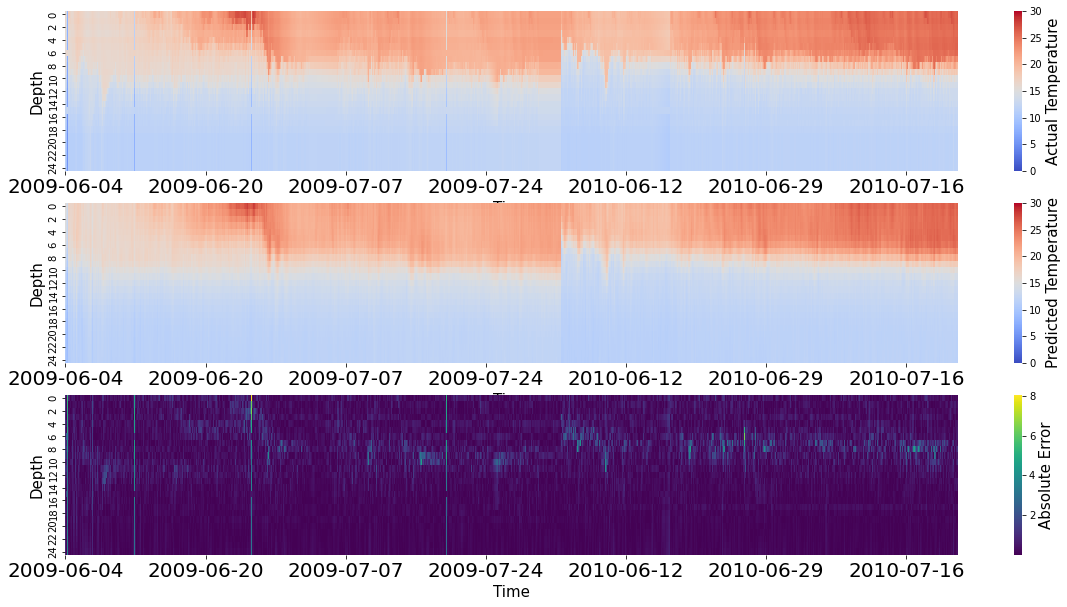

In [27]:
plot_output(train_y_pred, train_y_true, depth_steps, train_time, figsize=(20,10))

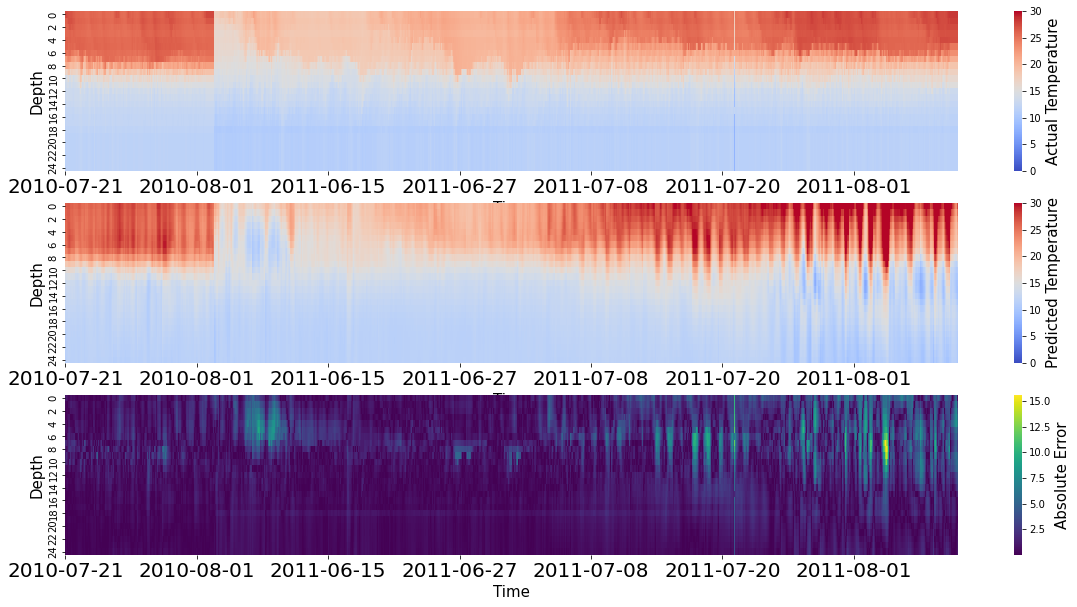

In [28]:
plot_output(test_y_pred, test_y_true, depth_steps, test_time, figsize=(20,10))

In [29]:
print(train_data.shape)
print(test_data.shape)

(63700, 21)
(42475, 21)


In [30]:
np.zeros((len(train_loader),1))

array([[0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.]])

In [31]:
len(train_loader)

63

In [32]:
x=iter(train_loader)
print(x)
x = x.to(device).float()

AttributeError: '_SingleProcessDataLoaderIter' object has no attribute 'to'